Before we start, let's load the files and libraries

In [61]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split

In [62]:
# Load csv as df
test_df = pd.read_csv("test_auto.csv")
train_df = pd.read_csv("train_auto.csv")

print("The initial number of rows of the test data set is ", "{:,}".format(len(test_df["INDEX"])))
print("The initial number of rows of the train data set is ", "{:,}".format(len(train_df["INDEX"])))


The initial number of rows of the test data set is  2,141
The initial number of rows of the train data set is  8,161


# 1. Initial Try

## 1. a) Clean the data

We start in 1. by using a straightforward method to clean the data. This involves:
- converting the columns with dollar price to integers
- removing the rows with at least one missing value in the train data set
- replacing missing values in the test data set with most frequent values
- correcting the typos
- the columns with only 2 strings (for example, "yes" or "no") are converted to 0 or 1
- the columns with more strings are divided into multiple columns with 0 or 1 (using one hot encoding)

In [63]:
# this is to find the columns with dollar price

def find_price_columns(x):
    price_col = []
    for col in x.columns:
        if( x[col].dtypes =="object"):
            if "$" in x.loc[1,col]:
                price_col += [col]
    return price_col

In [64]:
# this is to convert the columns with prices in $ to int

def clean_price_column(x):
    try:
        return int(x.translate({ord('$'): None, ord(','): None}))
    except (ValueError, AttributeError):
        return np.NaN

In [65]:
# version where we delete rows with missing values

def clean_data(df, is_test, price_columns):
    
    # Remove rows with missing values in all columns except for TARGET_FLAG and TARGET_AMT
    if is_test == True:
        df = df.dropna(subset = df.columns[3:26])
    else:
    # if train data set, also remove rows if missing values in TARGET_FLAG and TARGET_AMT
        df = df.dropna()
        
    # Remove index column
    df = df.drop("INDEX",axis=1)
    df = df.applymap( lambda s: s.lower() if type(s) == str else s)
    
    # transform dollar number to numbers
    for col in price_columns:
        df[col] = df[col].apply(clean_price_column)
            
    # Correct typos z_
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace("z_","") if type(x) is str else x)

        # Transform columns with binary values to 0 or 1, except TARGET_FLAG
        values = df[col].unique()
        bin_columns_exclude = ["TARGET_FLAG"]
        if col not in bin_columns_exclude and len( values ) == 2 :
            df[col] = df[col].apply(lambda x: 1 if x == values[0] else 0)
    return df       


In [66]:
# version where we replace missing values with most frequent one

def clean_data_2(df, is_test, price_columns ):
    
    # Remove index column
    df = df.drop("INDEX",axis=1)
    df = df.applymap( lambda s: s.lower() if type(s) == str else s)
    
    # transform dollar number to numbers
    for col in price_columns:
            df[col] = df[col].apply(clean_price_column)
        
    # Correct typos z_
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x.replace("z_","") if type(x) is str else x)

        # Transform columns with binary values to 0 or 1, except TARGET_FLAG
        values = df[col].unique()
        bin_columns_exclude = ["TARGET_FLAG"]
        if col not in bin_columns_exclude and len( values ) == 2 :
            df[col] = df[col].apply(lambda x: 1 if x == values[0] else 0)
    
    # Replace missing values with most frequent in all columns except for TARGET_FLAG and TARGET_AMT
    if is_test == True:
        df.iloc[:,3:26] = df.iloc[:,3:26].fillna(df.mode().iloc[0])
    else:
     # if train data set, also replace missing values in TARGET_FLAG and TARGET_AMT    
        df = df.fillna(df.mode().iloc[0])
        
    return df  

In [67]:
# for the test data set, we replace missing value with most frequent one
test_df = clean_data_2( test_df, True, find_price_columns(test_df) )
# for the train data set, we delete rows with missings values
train_df = clean_data( train_df, False, find_price_columns(train_df) )

# hot encoding
clean_test = pd.concat([test_df.select_dtypes("number"), pd.get_dummies(test_df.select_dtypes(object))], axis=1)
clean_train = pd.concat([train_df.select_dtypes("number"), pd.get_dummies(train_df.select_dtypes(object))], axis=1)

print("The number of rows after cleaning of the train data set is ", "{:,}".format(len(clean_train["TARGET_FLAG"])))

clean_test.to_csv("1a_test_after_cleaning.csv")
clean_train.to_csv("1a_train_after_cleaning.csv")

The number of rows after cleaning of the train data set is  6,045


## 1. b) Run Machine Learning model

In [68]:
test_size = 0.2

# We want to predict target_flag based on the values in all the other columns except target_amt
x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_size)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
result = model.predict(X_test) # to compare with y test 

print("The accuracy score is", "{:.2f}".format(model.score(X_test, y_test)))
print( "The f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model.predict(z)
clean_test.to_csv("1b_test_results.csv")


The accuracy score is 0.78
The f1 score is 0.49


# 2. Suggested enhancements

## 2. a) Remove the least important categories

We will calculate the importance of each column in the previous model. We can use this to filter out the least important ones.

In [69]:
importance_threshold = 0.001
remove_indices = []
remove_categories = [];
keep_indices = []
keep_categories = [];

for (i,importance) in enumerate( model.feature_importances_ ):
    # print(x.columns[i],": ", "{:.2f}".format(importance))
    if( importance < importance_threshold):
        remove_indices += [i]
        remove_categories += [x.columns[i]]
    else:
        keep_indices += [i]
        keep_categories += [x.columns[i]]
        
print("\nWe can ignore these categories: \n", remove_categories)
print("\nWe keep these categories:\n", keep_categories)

clean_test = clean_test.drop(remove_categories,axis=1)
clean_train = clean_train.drop(remove_categories,axis=1)

x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

model_2 = GradientBoostingClassifier()
model_2.fit(X_train, y_train)
result = model_2.predict(X_test) 

print("\nThe accuracy score is", "{:.2f}".format(model_2.score(X_test, y_test)))
print( "The f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model_2.predict(z)
clean_test.to_csv("2a_test_results.csv")



We can ignore these categories: 
 ['HOMEKIDS', 'CLM_FREQ', 'EDUCATION_<high school', 'EDUCATION_masters', 'EDUCATION_phd', 'JOB_doctor', 'JOB_home maker', 'JOB_lawyer', 'JOB_professional', 'JOB_student', 'CAR_TYPE_panel truck', 'CAR_TYPE_pickup', 'CAR_TYPE_van']

We keep these categories:
 ['KIDSDRIV', 'AGE', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'RED_CAR', 'OLDCLAIM', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY', 'EDUCATION_bachelors', 'EDUCATION_high school', 'JOB_blue collar', 'JOB_clerical', 'JOB_manager', 'CAR_TYPE_minivan', 'CAR_TYPE_sports car', 'CAR_TYPE_suv']

The accuracy score is 0.79
The f1 score is 0.52


## 2. b) Test another missing values method

Instead of removing the rows of the train data set with at least 1 missing value, we replace the missing values with the most frequent value of the corresponding column.

In [70]:
# reset data
test_df  = pd.read_csv("test_auto.csv")
train_df = pd.read_csv("train_auto.csv")

# for both data sets, we replace missing value with most frequent one
test_df  = clean_data_2( test_df, True, find_price_columns(test_df) )
train_df = clean_data_2( train_df, False, find_price_columns(train_df) )

clean_test  = pd.concat([test_df.select_dtypes("number"), pd.get_dummies(test_df.select_dtypes(object))], axis=1)
clean_train = pd.concat([train_df.select_dtypes("number"), pd.get_dummies(train_df.select_dtypes(object))], axis=1)
#clean_test.to_csv("2b_test_after_cleaning.csv")
#clean_train.to_csv("2b_train_after_cleaning.csv")

print("The number of rows after cleaning of the train data set is ", "{:,}".format(len(clean_train["TARGET_FLAG"])))

x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

model_3 = GradientBoostingClassifier()
model_3.fit(X_train, y_train)
result = model_3.predict(X_test) 

print("\nThe accuracy score is", "{:.2f}".format(model_3.score(X_test, y_test)))
print( "The f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model_3.predict(z)
clean_test.to_csv("2b_test_results.csv")


The number of rows after cleaning of the train data set is  8,161

The accuracy score is 0.79
The f1 score is 0.50


## 2. c) Deeper look into education fields

We keep one education column only where we reflect the level of education by associating <high school with 0, high school with 1, etc.

In [71]:
test_df  = pd.read_csv("test_auto.csv")
train_df = pd.read_csv("train_auto.csv")
test_df  = clean_data_2( test_df, True, find_price_columns(test_df))
train_df = clean_data( train_df, False, find_price_columns(train_df) )

def clean_edu_column(x):
    level = {"<high school": 0, "high school": 1, "bachelors": 2, "masters": 3, "phd": 4}
    try:
        return level[x]
    except (ValueError, AttributeError):
        return np.NaN
    
test_df["EDUCATION"] = test_df["EDUCATION"].apply(clean_edu_column)
train_df["EDUCATION"] = train_df["EDUCATION"].apply(clean_edu_column)

clean_test  = pd.concat([test_df.select_dtypes("number"), pd.get_dummies(test_df.select_dtypes(object))], axis=1)
clean_train = pd.concat([train_df.select_dtypes("number"), pd.get_dummies(train_df.select_dtypes(object))], axis=1)

#clean_train.to_csv("2c_ii_train_after_cleaning.csv")
#clean_test.to_csv("2c_ii_test_after_cleaning.csv")

x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_size)

model_5 = GradientBoostingClassifier()
model_5.fit(X_train, y_train)
result = model_5.predict(X_test) 

print("\nThe accuracy score is", "{:.2f}".format(model_5.score(X_test, y_test)))
print( "The f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model_5.predict(z)
clean_test.to_csv("2c_test_results.csv")




The accuracy score is 0.79
The f1 score is 0.52


## 2. d) Analyse correlation before running

We perform some correlation analysis on the initial data. We drop the columns with small absolute correlation with TARGET_FLAG.

The absolute value of the correlations with TARGET_FLAG are:
 TARGET_FLAG    1.000000
TARGET_AMT     0.541242
MVR_PTS        0.230171
CLM_FREQ       0.228004
URBANICITY     0.226721
HOME_VAL       0.184516
PARENT1        0.162017
CAR_USE        0.160423
INCOME         0.148034
REVOKED        0.142795
OLDCLAIM       0.138721
MSTATUS        0.131525
AGE            0.115274
HOMEKIDS       0.111866
BLUEBOOK       0.111521
CAR_AGE        0.110253
KIDSDRIV       0.086933
TIF            0.078885
YOJ            0.066429
TRAVTIME       0.051459
RED_CAR        0.025165
SEX            0.024006
Name: TARGET_FLAG, dtype: float64

 We apply an absolute correlation threshold of 0.1 and we remove the following columns:
 ['KIDSDRIV', 'TIF', 'YOJ', 'TRAVTIME', 'RED_CAR', 'SEX']


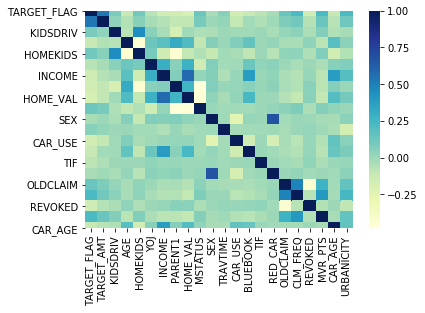

In [72]:
test_df  = pd.read_csv("test_auto.csv")
train_df = pd.read_csv("train_auto.csv")
test_df  = clean_data_2( test_df, True, find_price_columns(test_df) )
train_df = clean_data( train_df, False, find_price_columns(train_df) )

# pearson correlation
corr_matrix = train_df.corr();
corr_target_flag = abs(corr_matrix.loc["TARGET_FLAG",:])
corr_target_flag = corr_target_flag.sort_values(ascending = False)

sns.heatmap(corr_matrix,cmap="YlGnBu")
print("The absolute value of the correlations with TARGET_FLAG are:\n",corr_target_flag)

corr_threshold = 0.1

# find which fiels are below the correlation threshold
drop = []
for (i,key) in enumerate(corr_target_flag.axes[0]):
    if corr_target_flag[i] < corr_threshold:
        drop += [key]
        
print("\n We apply an absolute correlation threshold of", corr_threshold, "and we remove the following columns:\n", drop)

test_df  = test_df.drop( columns = drop )
train_df = train_df.drop( columns = drop)


In [73]:
clean_test = pd.concat([test_df.select_dtypes('number'), pd.get_dummies(test_df.select_dtypes(object))], axis=1)
clean_train = pd.concat([train_df.select_dtypes('number'), pd.get_dummies(train_df.select_dtypes(object))], axis=1)

x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

model_6 = GradientBoostingClassifier()
model_6.fit(X_train, y_train)
result = model_6.predict(X_test) 

print("\nThe accuracy score is", "{:.2f}".format(model_6.score(X_test, y_test)))
print( "The f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model_6.predict(z)
clean_test.to_csv("2d_test_results.csv")



The accuracy score is 0.79
The f1 score is 0.52


## 2. e) Test another model

In [74]:
# Let's test support vector machine

test_df     = pd.read_csv("test_auto.csv")
train_df    = pd.read_csv("train_auto.csv")
test_df     = clean_data_2( test_df, True, find_price_columns(test_df) )
train_df    = clean_data( train_df, False, find_price_columns(train_df) )
clean_test  = pd.concat([test_df.select_dtypes("number"), pd.get_dummies(test_df.select_dtypes(object))], axis=1)
clean_train = pd.concat([train_df.select_dtypes("number"), pd.get_dummies(train_df.select_dtypes(object))], axis=1)

x = clean_train.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
y = clean_train["TARGET_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= test_size)

model_7 = svm.NuSVC()
model_7.fit(X_train, y_train)

result = model_7.predict(X_test) # to compare with y test 

print("The accuracy score with SVM is", "{:.2f}".format(model_7.score(X_test, y_test)))
print( "f1 score is", "{:.2f}".format(f1_score(y_test, result)))

z = clean_test.drop(columns = ["TARGET_FLAG","TARGET_AMT"])
clean_test["TARGET_FLAG"] = model_7.predict(z)
clean_test.to_csv("2e_test_results.csv")


The accuracy score with SVM is 0.59
f1 score is 0.39


## 3. Results and considerations

We started in 1. by using a straightforward method to clean the data and to compute results. We then tested new strategies in 2:
- In 2.a), we used the importance of each column to filter out some columns with low importance. Given the accuracy score doesn't change, we can drop some columns.
- In 2.b), we used the same missing values strategy for the train data set than for the test data set (most frequent value). We could use other indicators too (mean for numbers for example). We could also look at guessing the missing values given data from the most correlated column.
- In 2.c), we kept one education column only but we reflected the gradual level of education.
- In 2.d), we performed an analysis of the absolute pearson correlation between the columns. We filtered out some columns with low correlation with TARGET_FLAG. We suggest we could look at other correlation methods in the future.
- In 2.e), we used a different model: support vector machine. We found a lower accuracy score so we suggest we stick to GradientBoostingClassifier.

We notice that these different methods have not materially improved the accuracy score.
However, we learnt from 2.b) that dropping certain parameters do not change the accuracy score (HOMEKIDS, EDUCATION_<high school, EDUCATION_bachelors, EDUCATION_phd, JOB_doctor, JOB_home maker, JOB_lawyer, JOB_professional, CAR_TYPE_panel truck & CAR_TYPE_pickup). On the other hand, some parameters seem to be important (OLDCLAIM & URBANICITY).

In the above, I used the accuracy score and f1 score metrics to judge the performance of the model.
Depending on what we are trying to model here, false positive and false negatives might be important to consider, and hence we might want to look at the f1 score instead of the accuracy score.

I think that this algorithm tries to predict whether a certain customer buys an object (1) or not (0). If they bought it, they paid the TARGET_AMT (which is different from 0 if and only if the customer bought the object).
At such, I believe that we might be missing some parameters linked to human factors that cannot be measured - there is a part of irrationality. There might be other parameters mising too. 